In [ ]:
# Import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="cbtJsKjDivb61gTUBXpeo48r7",
    project_name="general",
    workspace="michael-py",
)

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section we import the libraries that will be used throughout our analysis and modelling. |

---

In [1]:
# Libraries for data loading, data manipulation and data visulisation
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
from multiprocesspandas import applyparallel

%matplotlib inline
# set plot style
sns.set()

# Libraries for Natural Language processing
import nltk
from nltk.corpus import stopwords
# from gensim.parsing.preprocessing import STOPWORDS
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, PorterStemmer
from nltk.tokenize import TreebankWordTokenizer

# Libraries for data preparation and model building
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, classification_report
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Setting global constants to ensure notebook results are reproducible
SEED = 1



<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section we load the data from the `train.csv` file into a DataFrame. |

---

In [2]:
df = pd.read_csv('kaggle_data/train.csv', encoding='ascii', encoding_errors='ignore')# load the data

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, we perform an in-depth analysis of all the variables in the DataFrame. |

---


### What is EDA?

- In a nutshell, exploratory data analysis (EDA) is what data analysts do with large amounts of data to uncover patterns and summarize the dataset's primary characteristics in addition to what they learn from modeling and hypothesis testing. EDA is a notion in data analytics that allows analysts to approach a database without making any assumptions. When a data analyst employs EDA, it's as if the data is revealing what they don't already know.

In [3]:
# take a peek into the dataset
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


Here we take a quick peek into our loaded dataset and we see that there are __3__ columns of note; `sentiment`, `message` and `tweetid`

A further investigation will provide the dimensions of our dataset, that is looking at the `shape` of the data

In [4]:
df.shape

(15819, 3)

Here, we can see that our dataset is made up of __15,819__ rows and __3__ columns, as was earlier revealed.

Next let's see of all that number of data points in the dataset, how many of them do not contain any data? and what kind of data is contained in each column? These questions will be answered by looking at the information of the dataset provided by the `.info()` method.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 309.0+ KB


The information above tells us that all of the columns in our dataset contain __15,819__ rows of data that `non-null`, meaning we have no missing values in our dataset. This can be attested to by the information provided when we looked at the `shape` of the data above

Another interesting information to extract from this dataset will be the unique labels in the `sentiment` which is our `label` or `dependent variable`

In [6]:
sentiment_labels = list(df.sentiment.unique())
print(sentiment_labels)

[1, 2, 0, -1]


We have __4__ different labels which make up the list of all possible sentiments that can be predicted by our model(s)

__-1__: means it is a NEGATIVE sentiment
__0__: means it is a NEUTRAL sentiment
__1__: means it is a POSITIVE sentiment
__2__: means it is a FACTUAL sentiment from a reputable News Site

What are the proportions of our dataset that these labels represent? First, we will look at the figures and then we will look at a chart for better understanding  

In [7]:
labels_proportions = df.sentiment.value_counts()
labels_proportions.index = ['positive', 'factual', 'neutral', 'negative']
labels_proportions

positive    8530
factual     3640
neutral     2353
negative    1296
Name: sentiment, dtype: int64

We can see that _label 1_ is very highly represented (__8,530__) and _label 2_ follows not so closely (__3,640__), which can be a good thing because it indicates that a lot of people are speaking about climate change and are aware of its impacts on our planet. _Label 0_ comes in third (__2,353__); these tweets are neutral, having no connections with climate change or its woes.

Gladly, the negative sentiments come in tops from the bottom (__1,296__). These are tweets from people that do not believe in the reality of climate change or global warming

Now the chart.

In [8]:
def plot_series(series, kind='pie', name='sentiment'):
    import matplotlib as mpl
    mpl.rcParams['xtick.labelsize'] = 12 
    series.index = ['positive', 'factual', 'neutral', 'negative']
    series.plot(kind=kind, figsize=(12, 9))
    plt.ylabel(name, fontsize=14)
    plt.xticks(rotation=0)
    plt.title(f'Proportion of {name}s', fontsize=16)
    return

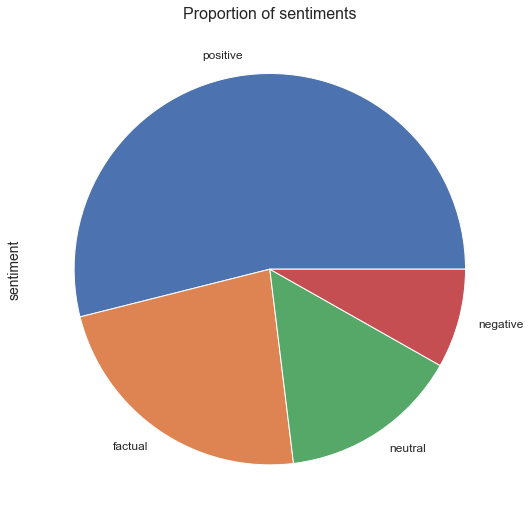

In [9]:
plot_series(labels_proportions)

Here we see that the biggest slice of the pie represents the _positive comments_ followed by the _factual comments/posts_ and so on, confirming what we understand from the figures

While we are glad that there are more _positive_ comments than the _neutral_ and _negative_ ones combined, this poses an issue when we try to feed the data into our machine learning algorithm. This is as a result of an __imbalance__ of the proportion of data represented by the labels in our dataset. We will dive into that further in the **data engineering** section; what data imbalance is and how to deal with it.

Out of curiosity, While it is intuitive to spot a _postive_ or a _negative_ or a _neutral_ comment, what makes a comment *factual*? hmm..

Let's look further into the data and see what we find.

We will approach this by printing a sample of messages in these different comment categories and see if we can make sense of what we find.

In [10]:
positives = df['message'][df['sentiment'] == 1]
negatives = df['message'][df['sentiment'] == -1]
neutrals = df['message'][df['sentiment'] == 0]
factuals = df['message'][df['sentiment'] == 2]

print("Positive comments:")
print(f"\t{np.array(positives[:5])}\n")

Positive comments:
	["PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable"
 "It's not like we lack evidence of anthropogenic global warming"
 '#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD'
 "RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight"
 "Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j"]



In [11]:
print("Negative comments:")
print(f"\t{np.array(negatives[:5])}\n")

Negative comments:
	['Sally Kohns latest evidence of climate change proves she is not a smart person https://t.co/MhkzoGL9Vt via @twitchyteam Need we say more'
 "@realDonaldTrump Carbon Tax is a Globalist idea to enslave the world's population. It is the whole reason for propagating global warming!"
 'RT @SteveSGoddard: We had winds close to 100 MPH in the area this afternoon. I would blame climate change, except that this happens pr '
 '@MissLizzyNJ lmao  snowflakes  complaining about snowflakes  in winter =global warming '
 "RT @Dawn2334Dawn: This is ONE of Arnold Schwarzenegger's vehicles. He is now whining about climate change.\nHow's his maid...illegal or\nhttp"]



In [12]:
print("Neutral comments:")
print(f"\t{np.array(neutrals[:5])}\n")

Neutral comments:
	['Calum: *tweets abt reunitingish w the cast*\n-sees replies begging him to come to their countries-\nCalum: *goes back to rting climate change*'
 'we also met this guy, he let us in on some truth about climate change and gay people not existing https://t.co/Q7yOMcMZaj'
 "@Jnp_Ftw are these the same scientists that denounce climate change? It's not a choice"
 'We ve dealt with simple issues like climate change and energy policy. Now the complex issues. Mal vs Tones. #qanda'
 "RT @andrewsharp: Win probability is bullshit man. I saw the NBA Finals and that's when I knew, global warming isn't real"]



In [13]:
print("Factual comments:")
print(f"\t{np.array(factuals[:5])}\n")

Factual comments:
	['RT @RawStory: Researchers say we have three years to act on climate change before its too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT'
 'RT @tveitdal: We only have a 5 percent chance of avoiding dangerous global warming, a study finds https://t.co/xUBTqNxhkK https://t.co/of'
 'Fossil fuel giant ExxonMobil misled the public about climate change, Harvard academics conclude https://t.co/ofc2WSu4EX'
 'Bangladesh confronting climate change head on https://t.co/MTqeNBQDUt https://t.co/itgkUxgEfg'
 'RT @latimes: Atmospheric rivers fueled by climate change could decimate wild oysters in San Francisco Bay https://t.co/p0LZBhlU5K https://t']



At first glance, nothing particularly stands out but looking closely, only factual comments have posts from news sites like **@RawStory** and **@latimes**. A quick research into **@tveitdal** shows that he is a grandmaster in climate change and environmental consultancy, but are we to take his words as facts? hmm.. We will dive into this further during **data engineering**. 

There are no surprises in the _negative_ comments, there's a post with Donald Trump tagged.

There also seem to be a lot of links in these posts. These have to be handled one way or another as they will become "noise" in the data set. In the meantime, let's investigate this further.

**What are the words that are more frequent in each post type**

In [14]:
def words_freq(df, n):
    import string
    stop_words = stopwords.words('english')
    stop_words.append('rt')
    stop_words.append('&amp;')
    dict_ = {}
    for row in np.array(df):
        word_sw = ' '.join([l.lower().strip() for l in row.split(' ') if l.lower() not in stop_words])
        word_punct = ''.join([l for l in word_sw if l not in string.punctuation])

        for wd in word_punct.split(" "):
            if wd != '':
                if wd in dict_:
                    dict_[wd] += 1
                else:
                    dict_[wd] = 1
    
    dict_ = {k: v for k,v in sorted(dict_.items(), key=lambda kv: kv[1], reverse=True)}
    n_largest = dict(list(dict_.items())[:n])
    
    return n_largest

In [15]:
pos = words_freq(positives, 200)
print(pos)

{'climate': 7349, 'change': 7063, 'global': 1595, 'warming': 1430, 'believe': 1004, 'trump': 888, 'going': 590, 'real': 497, 'people': 454, 'world': 446, 'us': 444, 'die': 394, 'thinking': 338, 'hoax': 317, 'husband': 312, 'like': 310, 'stephenschlegel': 307, 'httpstcosjofon': 307, 'fight': 285, 'new': 283, 'https': 276, 'epa': 271, 'sensanders': 248, 'say': 246, 'science': 237, 'think': 236, 'need': 235, 'thinks': 219, 'president': 207, 'action': 202, 'via': 199, 'donald': 196, 'right': 195, 'presidentelect': 193, 'trumps': 191, 'know': 190, 'planet': 186, 'denier': 186, 'deniers': 177, 'im': 177, 'one': 172, 'scientists': 171, 'must': 164, 'realdonaldtrump': 164, 'stop': 164, 'still': 164, 'make': 160, 'chinese': 157, 'future': 155, 'millions': 154, 'watch': 152, 'mr': 151, 'earth': 151, 'take': 146, 'beforetheflood': 145, 'time': 141, 'could': 137, 'would': 137, 'want': 134, 'combat': 133, 'really': 133, 'years': 132, 'thats': 131, 'see': 130, 'get': 130, 'weather': 130, 'htt': 129,

In [16]:
neg = words_freq(negatives, 200)
print(neg)

{'climate': 796, 'change': 735, 'global': 635, 'warming': 604, 'science': 78, 'realdonaldtrump': 70, 'us': 63, 'real': 60, 'people': 57, 'trump': 57, 'man': 53, 'scam': 51, 'would': 50, 'hoax': 50, 'fake': 48, 'made': 48, 'data': 48, 'manmade': 46, 'believe': 46, 'stevesgoddard': 44, 'make': 42, 'years': 42, 'obama': 41, 'like': 41, 'gore': 40, 'news': 36, 'al': 36, 'money': 36, 'scientists': 35, 'world': 34, 'one': 33, 'cause': 33, 'tax': 32, 'know': 32, 'chinese': 31, 'it': 30, 'liberals': 30, 'left': 29, 'weather': 29, 'think': 29, 'scientist': 28, 'good': 28, 'going': 28, 'created': 28, 'order': 27, 'leaders': 27, 'say': 26, 'due': 26, 'concept': 26, 'caused': 26, 'ice': 26, 'https': 25, 'get': 25, 'manufacturing': 25, 'stop': 25, 'hell': 25, 'time': 24, 'manipulated': 24, 'new': 23, 'noncompetitive': 23, '2': 22, 'earth': 22, 'ever': 22, 'via': 21, 'want': 21, 'outside': 21, 'liberal': 21, 'alarmists': 20, 'im': 20, 'prisonplanet': 20, 'day': 20, 'fraud': 20, 'nothing': 20, 'co2':

In [17]:
neu = words_freq(neutrals, 200)
print(neu)

{'climate': 1436, 'change': 1372, 'global': 1037, 'warming': 966, 'trump': 148, 'us': 101, 'like': 96, 'real': 94, 'believe': 87, 'im': 86, 'penguin': 84, 'think': 82, 'hes': 78, 'people': 65, 'cause': 56, 'know': 52, 'one': 49, 'says': 45, 'get': 45, 'club': 44, 'new': 44, 'said': 44, 'would': 43, 'hot': 43, 'thing': 40, 'good': 39, 'world': 39, 'thats': 37, 'weather': 37, 'need': 37, 'care': 37, 'great': 36, 'right': 36, 'still': 35, 'https': 35, 'going': 35, 'really': 34, 'want': 34, 'say': 33, 'even': 33, 'talk': 33, 'stop': 32, 'time': 32, 'much': 31, 'man': 30, 'realdonaldtrump': 30, 'hoax': 30, 'leonardo': 30, 'tell': 30, 'make': 30, 'science': 29, 'today': 29, 'cant': 29, 'asked': 28, 'u': 28, 'it': 28, 'epa': 28, 'come': 27, 'see': 27, 'china': 26, 'cold': 26, 'what': 26, 'well': 25, 'day': 25, 'could': 25, 'told': 25, 'years': 25, 'c': 25, 'expect': 25, 'also': 24, 'scientists': 24, 'via': 24, 'trumps': 24, 'look': 24, 'kind': 24, 'me': 24, 'energy': 23, 'yes': 23, 'winter': 

In [18]:
fact = words_freq(factuals, 200)
print(fact)

{'climate': 3348, 'change': 3206, 'trump': 825, 'global': 507, 'warming': 436, 'via': 299, 'us': 293, 'says': 241, 'trumps': 239, 'epa': 237, 'new': 191, 'scientists': 178, 'donald': 166, 'fight': 159, 'china': 143, 'could': 133, 'news': 125, 'world': 114, 'scott': 112, 'paris': 110, 'energy': 101, 'chief': 100, 'president': 100, 'study': 98, 'pruitt': 96, 'science': 94, 'may': 93, 'plan': 88, 'thehill': 82, 'agreement': 81, 'exxon': 81, 'https': 80, 'cnn': 80, 'carbon': 79, 'obama': 78, 'head': 76, 'environment': 76, 'report': 72, 'tillerson': 71, 'house': 69, 'reuters': 68, 'climatechange': 67, 'say': 66, 'un': 66, 'guardian': 65, 'back': 65, 'website': 64, 'order': 64, 'years': 60, 'httpstco': 60, 'due': 59, 'rex': 58, 'leaders': 58, 'action': 57, 'primary': 57, 'dioxide': 56, 'httpst': 55, 'white': 55, 'government': 55, 'arctic': 55, 'calls': 54, 'research': 54, 'california': 53, 'independent': 52, 'used': 51, 'policy': 51, 'contributor': 50, 'efforts': 49, 'department': 48, 'state

#### - *words that make a comment factual*

In [19]:
facts= list(set(fact.keys()) - set(list(neg.keys()) + list(pos.keys()) + list(neu.keys())))

In [20]:
post= list(set(pos.keys()) - set(list(neg.keys()) + list(fact.keys()) + list(neu.keys())))

In [21]:
negt= list(set(neg.keys()) - set(list(pos.keys()) + list(fact.keys()) + list(neu.keys())))

In [22]:
neut = list(set(neu.keys()) - set(list(pos.keys()) + list(fact.keys()) + list(neg.keys())))

In [23]:
def word_cloud(data, sentiment):
    from wordcloud import WordCloud
    # Create a variable to store the text
   
    text = " ".join(word for word in data)
    # Instantiate wordcloud object
    word_cloud = WordCloud(collocations =True,
                          background_color = 'Black',
                          width=400, 
                          height=300, 
                          contour_width=2, 
                          contour_color='steelblue')
    # generate wordcloud images
    word_cloud.generate(text)
    # Create Plot
    
    plt.figure(figsize =(10,10))
    plt.imshow(word_cloud, interpolation ='bilinear' )
    plt.axis('off')
    plt.title('Most Frequent Words in sentiment {}'.format(sentiment), size = 25, pad =15)
    plt.show()

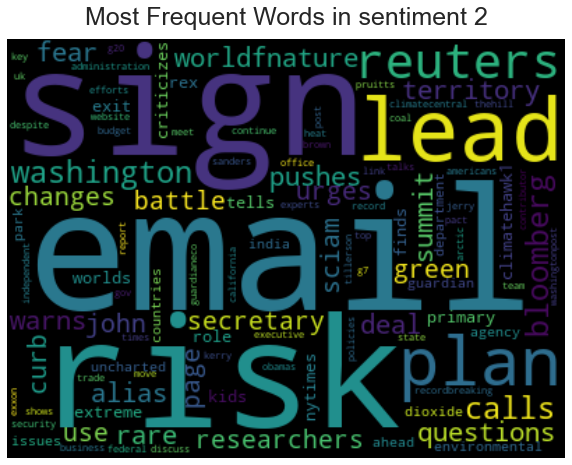

In [24]:
word_cloud(facts, 2)

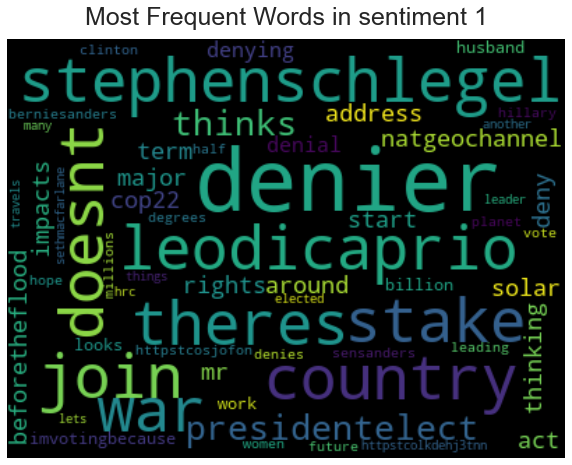

In [25]:
word_cloud(post, 1)

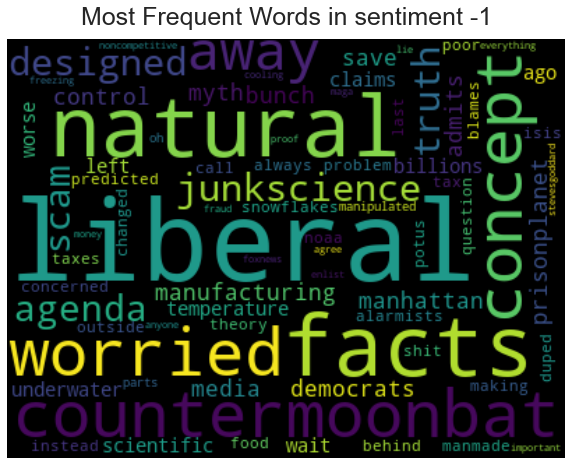

In [26]:
word_cloud(negt, -1)

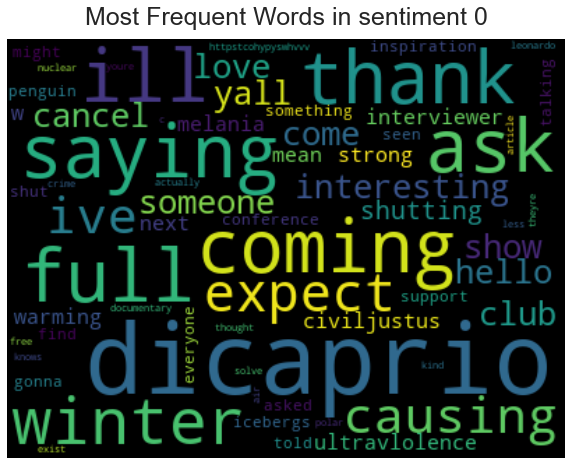

In [27]:
word_cloud(neut, 0)

So far we've taken a look at what the most frequent words are per sentiment and have seen how factual comments differ from other comments after taking a look at the top 20 frequent words. A few words of interest are "epa", "news", "scientists" and "via" which all tend to be words used in a news site publication

**Note**, our data is still a bit noisy because we haven't taken care of the urls in each post yet. But this gives us an idea.

**How many links are there in total? and How are they shared amongst the sentiments?**

In [28]:
# how many links there are
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
urls = []
for row in df['message']:
    match = re.findall(pattern_url, row)
    for item in match:
        urls.append(item)

total_links = len(urls)
print(total_links)

9673


Here we see that there are __9,673__ url links in the dataset.

In [29]:
# Number of links per sentiment

# copy dataframe to not change structure of main df
df_copy = df.copy()

# create new column `url
url = []

# find urls per row 
for row in df_copy['message']:
    match = re.findall(pattern_url, row)
    url.append(len(match)) # append the number of urls found per row
    
df_copy['url'] = url

df_copy.head()

,sentiment,message,tweetid,url
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,1
1,1,It's not like we lack evidence of anthropogeni...,126103,0
2,2,RT @RawStory: Researchers say we have three ye...,698562,2
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,1
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,0


In [30]:
count_dict = {}

for l in df_copy.sentiment.unique():
    new_df = df_copy[df_copy.sentiment == l]
    count_dict[l] = sum(new_df.url)
    
count_dict

{1: 4199, 2: 4070, 0: 865, -1: 539}

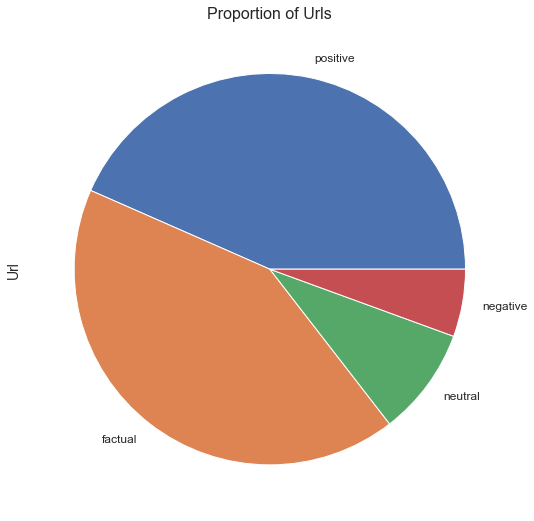

In [31]:
plot_series(pd.Series(count_dict), name='Url')

Again, _positive_ and _factual_ comments lead the way, indicating that there may be more to gain from these urls, particularly in the case of the _factual_ comments which has more **urls** than it does **data points** (__4,070 :__ __3640__). This is by no means conclusive. 

Perhaps the model will tell us more eventually.

#### The Problem With Text Data

A major problem with *text* data is that it is very messy and requires a lot of cleaning. In addition to that, it comes in a form that will be very difficult to feed into our machine learning models and get meaningful results, if any for that matter.

A machine learning model only understands numbers in form of `ints` and `floats` and has a difficult time comprehending what alphabets represent.

To help our machine learn better and make its life more bearable, we will need to transform our text data into digits in such a way that translates what the text is to the machine in numbers, thereby retaining, up to level, the meanings of the text. To do this, we will be carrying out a concept called `Data Engineering`.

`Data Engineering` has been referred to a couple of times so far in this notebook, let's find out what it is next

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |
| In this section we will: clean the dataset, and possibly create new features - as identified in the EDA phase. |

---

### What is Data Engineering?

- Data engineering is the process of creating features that allow machine learning algorithms to work utilizing domain knowledge of the data. Feature engineering is both difficult and expensive, but it is essential to the application of machine learning.

#### Our Mission

- [X] Extract titles from Urls and incorporate findings into our data

- [X] Remove Stopwords

- [X] Remove hashtags and @usernames

- [X] Remove Punctuations

- [X] Tokenize text data

- [ ] Transform data(by stemming or lemmatizing)

- [ ] Vectorize data without resampling(by bag of words, countvectorizer or tfidfvectorizer)

- [ ] Vectorize data with resampling(by bag of words, countvectorizer or tfidfvectorizer)

1. ###  Extracting Titles for Urls

To achieve this goal, we will need to create a few functions for a cleaner process

In this section, we will extract the urls from the tweets and scrape the title from the webpage the url links to and then replace url with the title of the webpage to give the tweet message more context

There are cases where the tweet made and the title of the url extracted from the tweet are the same. This is a problem because the end goal of the extraction and handling of the url is to replace the url with the scraped title of the website, and with the tweet and the message being similar, it will lead to duplication of tweet message which will blow up the count of some words in the long run.

Let us look at an example: for tweet indexed 14551

In [32]:
tweet = df_copy.message[14551]
print(tweet)

In rare move, China criticizes Trump plan to exit climate change pact https://t.co/svDExQ7mlA via @Reuters


In [33]:
match = re.findall(pattern_url, tweet)
print(match)

['https://t.co/svDExQ7mlA']


In [34]:
# for url in match:
#     response = requests.get(url,verify=False)
#     soup = BeautifulSoup(response.text, 'html.parser')
#     for title in soup.find_all('title'):
#         print(title.get_text())

As we can see, the title is exactly the same as the message in the tweet. We do not want this to happen. To handle this problem, we will create a function that checks the similarity between the tweet message and the title from the url. Given a threshold, at about 40%, if the similarity between both texts is greater than or equal to the threshold, the url in the tweet message is replaced with _facturl_.

In [35]:
def check_title_similarity(text, title):
    """
    This function checks the similarity between
    the tweet message and the title scraped from
    the url link.
    """
    text = text.split(" ")
    title = title.split(" ")
    text_counter = set()
    title = set(title)
    
    for txt in title:
        if txt in text:
            text_counter.add(txt)
    
    perc_similarity = (len(text_counter)/len(title))*100
    
    return perc_similarity

Due to the size of our dataset, it will be difficult and computationally expensive to extract the urls from the tweets and get the url info and extract the title of the web page the url links to. That doesn't sound too difficult, but for a dataset in the tens of thousands, it is massively difficult especially on an average pc.

To help us with this problem, we employ the services of __multithreading__. A brief introduction into this concept will only be proper.

**What is Multithreading?**

- Multithreading is a popular Python technique that allows numerous jobs to run at the same time. Multithreading, in simple terms, is the ability of a processor to run many [threads](https://www.scaler.com/topics/multithreading-in-python) at the same time. 

Another concept of note is a concept called **[multiprocessing](https://www.scaler.com/topics/multithreading-in-python)** click on the link to read more.

We are going to be making use of the package `concurrent.futures`, it already exists in python's standard library so you do not need to install it.

Below, we create a function to extract the urls from the `message` column

In [36]:
def extract_urls(arr):

    urls = []
    count = 0
    start = time.perf_counter()
    
    for m in arr:
        pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
        match = re.search(pattern_url, m)
        
        if match is not None:
            urls.append(match.group())
            
        else:
            urls.append(None)
            
        count += 1
        
    tots = time.perf_counter() - start
    
    return urls

In [37]:
messages = np.array(df_copy['message'])
url_list = extract_urls(messages)

In [38]:
def get_title(url):
    url_titles = []
    try:
        try:
            response = requests.get(url,verify=False, timeout=15)

        except:
            url = 'https://www.google.com'

        finally:
            response = requests.get(url,verify=False)
            soup = BeautifulSoup(response.text, 'html.parser')
            for title in soup.find_all('title'):
                if title:
                    return title.get_text()
                else:
                    return ("")
    except:
        pass

Here's a function called `download_titles` which makes use of python's multithreading which maps the `get_title` function over each url in a list of urls

In [39]:
def download_titles(urls):
    import concurrent.futures
    titles = []
    MAX_THREADS = 30
    start = time.perf_counter()
    
    threads = min(MAX_THREADS, len(urls))
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        title = executor.map(get_title, urls)
        for i, tit in enumerate(title):
            titles.append(tit)
            print(i, tit)
            
    end = time.perf_counter() - start
    
    print(f"done {len(urls)} in {end} secs")
    
    return titles

The code below calls the `download_titles` function, passes in a list of urls and stores the downloaded titles in a titles variable. 

**Warning:** this bit practically took about an hour and three quarters to execute, don't believe me? here's proof; [done **15819** jobs in **5746.6804334 secs**  that is about **1 hour, 40 mins**]. 

Still don't believe me? grab a cup of coffee, some snacks and turn on Netflix to your favorite show and have at it (uncomment the code cell below), because it is going to take that long. 

Well... except your machine is way better than mine ...and i bet it is.

In [40]:
# titles = download_titles(url_list)

# titles

The result of the above code has been saved into a CSV file as `titles.csv` and can be read in for ease of use.

In [41]:
titles = pd.read_csv('titles.csv')

titles.head()

,Unnamed: 0,0
0,0,EPA chief denies carbon dioxide is main cause ...
1,1,Google
2,2,Google
3,3,2016 Was a Pivotal Year in the War on Climate ...
4,4,Google


Let's clean up a bit

- #### Cleaning *titles* dataframe

We will drop the unwanted column `unnamed:0` because it is merely an index column that came with the file and give the column containing titles a befitting name

In [42]:
titles.drop('Unnamed: 0', axis=1, inplace=True)
titles.columns = ['title']

titles.head()

,title
0,EPA chief denies carbon dioxide is main cause ...
1,Google
2,Google
3,2016 Was a Pivotal Year in the War on Climate ...
4,Google


That looks better

*Google* is only a placeholder for links that lead nowhere or have restrictions and will not be treated as text of interest but removed.

There are some rows with invalid data or website error messages such *404 Not Found* etc. We have a list of titles to remove and are stored in `titles.txt` file. Let's read that in.

In [43]:
with open('titles.txt', 'r') as file:
    bad_titles = file.readlines()
    file.close()
    
bad_titles = [w.lower().replace('\n', '') for w in bad_titles]
bad_titles

['google',
 'none',
 '403 forbidden',
 'file not found',
 'page not found',
 '404 not found',
 '404 page not found',
 'twitter',
 'youtube',
 'scihubbz',
 'tco twitter',
 '500 internal server error',
 'short url blocked',
 'sorry something went wrong',
 'attention required',
 'error: the request could not be satisfied',
 '405 you have been blacklisted',
 'not acceptable',
 'facebook',
 'sciencedirect',
 'are you a robot',
 'just a moment',
 'whoops',
 'service unavailable',
 'website firewall - access denied']

In [44]:
titles.fillna('google', inplace=True)

Again, 'google' is just a placeholder

Next, we will remove punctuations from our `titles` dataframe, employing the use of the `remove_punctuations` function

In [45]:
def remove_punctuations(text):
    import re
    # using regex to remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [46]:
titles['title'] = titles['title'].apply_parallel(remove_punctuations)

Now, Let's remove those bad titles.

We will approach this by using the `*.__contains__*` string class method

In [47]:
def remove_bad_titles(title, remove_titles=bad_titles):
    title = title.lower()
    title = title.strip()
    for bt in remove_titles:
        if title.__contains__(bt):
            split_title = title.split(bt)
            title = "".join(split_title)
    
    return title

In [48]:
titles['title'] = titles['title'].apply_parallel(remove_bad_titles)

In [49]:
titles.head()

,title
0,epa chief denies carbon dioxide is main cause ...
1,
2,
3,2016 was a pivotal year in the war on climate ...
4,


Okay! everything is looking good thus far

- #### Merge tweet messages with extracted titles

Next, lets merge these titles to our tweet messages

In [50]:
def merge_msg(main_df, main_col, title_df, title_col):
    rows = []
    
    for i in range(len(title_df)):
        if check_title_similarity(main_df[main_col][i], title_df[title_col][i]) >= 40:
            rows.append(main_df[main_col][i] + ' relatedurl')
        else:
            rows.append(main_df[main_col][i] + ' unrelatedurl ' + title_df[title_col][i].strip())
        
    main_df[main_col] = rows
    
    return main_df

<span style='color: red'><em>NB: Adding the titles to the tweets did not make the model predict better</em></span>

Uncomment the code below to add the tweets to their titles

In [51]:
# df = merge_msg(df_copy, 'message', titles, 'title')

In [52]:
df.head(10)

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954
5,1,Worth a read whether you do or don't believe i...,425577
6,1,RT @thenation: Mike Pence doesnt believe in gl...,294933
7,1,RT @makeandmendlife: Six big things we can ALL...,992717
8,1,@AceofSpadesHQ My 8yo nephew is inconsolable. ...,664510
9,1,RT @paigetweedy: no offense but like how do yo...,260471


Next we remove the links in each message as we have already extracted information from the useful ones

- #### Remove web links from text

In [53]:
def handle_weblinks(text):
    import re
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    match = re.findall(pattern_url, text)
    
    for sub in match:
        text = re.sub(pattern_url, '', text)
    return text.strip().lower()

In [54]:
df['message'] = df['message'].apply_parallel(handle_weblinks)

In [55]:
np.array(df['message'])[:10]

array(["polyscimajor epa chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!?  via @mashable",
       "it's not like we lack evidence of anthropogenic global warming",
       'rt @rawstory: researchers say we have three years to act on climate change before its too late',
       '#todayinmaker# wired : 2016 was a pivotal year in the war on climate change',
       "rt @soynoviodetodas: it's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #electionnight",
       "worth a read whether you do or don't believe in climate change",
       'rt @thenation: mike pence doesnt believe in global warming or that smoking causes lung cancer.',
       'rt @makeandmendlife: six big things we can all do today to fight climate change, or how to be a climate activist  h',
       '@aceofspadeshq my 8yo nephew is inconsolable. he wants to die of old age like me, but will perish in the fiery hellscape of climate change.',
       'rt @paigetwee

Okay! that's done. We have successfully finished the first mission. Hurray!

- [X] Extract titles from Urls and incorporate findings into our data

Next up on our mission is to remove stopwords from our texts

2. ###  Remove Stopwords

#### What are Stopwords?

Stopwords are words that are quite common in human language but are often useless since they represent words like "the," "of," and "to."

Apart from the universally known stopwords, there are words that are perculiar to some industries or particular topics and content that may be regarded as stop words. For instance, in our case where we are dealing with tweets, "RT" which stands for "Retweet" can be considered a stop word, also @Usernames and #topics may be considered as stopwords.

Let's remove these bits of texts from the messages in our dataset

In [56]:
def remove_stopwords(text):
    text = text.lower()
    will_pattern = r'(\'ll)'
    would_pattern = r'(\'d)'
    is_pattern = r'(\'s)'
    am_pattern = r'(\'m)'
    not_pattern = r'(n\'t)'
    
    will_match = re.findall(will_pattern, text)
    would_match = re.findall(would_pattern, text)
    is_match = re.findall(is_pattern, text)
    am_match = re.findall(am_pattern, text)
    not_match = re.findall(not_pattern, text)
    
    for sub in will_match:
        text = re.sub(will_pattern, ' will', text)
        
    for sub in would_match:
        text = re.sub(would_pattern, ' would', text)
        
    for sub in is_match:
        text = re.sub(is_pattern, ' is', text)
        
    for sub in am_match:
        text = re.sub(am_pattern, ' am', text)
    
    for sub in not_match:
        text = re.sub(not_pattern, ' not', text)
        
    #  REMOVING STOPWORDS MAKES THE ALGORITHM PERFORM LESS (70% ACCURACY)
    # NOT REMOVING STOP WORDS (73% ACCURACY)
    
    # stop_words = stopwords.words('english')
    # stop_words.remove('not')
    # stop_words = stop_words + ['&amp;', '&amp', 'rt', 'amp']
    
    stop_words = ['&amp;', '&amp', 'rt', 'amp']
    text = " ".join([word for word in text.split(" ") if word not in stop_words])
    text = " ".join([word for word in text.split("\n") if word not in stop_words])
    
    return text

In [57]:
df['message'] = df['message'].apply(remove_stopwords)

In [58]:
df.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief does not think carbon d...,625221
1,1,it is not like we lack evidence of anthropogen...,126103
2,2,@rawstory: researchers say we have three years...,698562
3,1,#todayinmaker# wired : 2016 was a pivotal year...,573736
4,1,"@soynoviodetodas: it is 2016, and a racist, se...",466954


- [X] Remove stopwords

3. ###  Handle tagged usernames and hashtags

In [59]:
def handle_tags(text):
    pattern_at = r'@(?:[A-Za-z]|[0-9]|[$-_@.&+#])+'
    pattern_hash = r'#(?:[A-Za-z]|[0-9]|[$-_@.&+#])+'
    
    match = re.findall(pattern_hash, text)
    at_match = re.findall(pattern_at, text)
    
    for sub in match:
        text = re.sub(pattern_hash, ' target ' , text)
   
    for sub in at_match:
        text = re.sub(pattern_at, ' tag ', text)

    return text.strip()

In [60]:
df['message'] = df['message'].apply(handle_tags)

In [61]:
df.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief does not think carbon d...,625221
1,1,it is not like we lack evidence of anthropogen...,126103
2,2,tag researchers say we have three years to ac...,698562
3,1,target wired : 2016 was a pivotal year in the...,573736
4,1,"tag it is 2016, and a racist, sexist, climate...",466954


Next, we will be getting rid of punctuations from out dataset.

- [X] Remove usernames and hashtags

4. ### Remove Punctuations

Here we will be making use of the `remove_punctuations` function

In [62]:
def remove_punctuations(text):
    import re
    # using regex to remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [63]:
df['message'] = df['message'].apply_parallel(remove_punctuations)

In [64]:
df.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief does not think carbon d...,625221
1,1,it is not like we lack evidence of anthropogen...,126103
2,2,tag researchers say we have three years to ac...,698562
3,1,target wired 2016 was a pivotal year in the ...,573736
4,1,tag it is 2016 and a racist sexist climate ch...,466954


- [X] Remove punctuations

#### Mission Check Point

- [X] Extract titles from Urls and incorporate findings into our data

- [X] Remove Stopwords

- [X] Remove hashtags and @usernames

- [X] Remove Punctuations

- [ ] Tokenize text data

- [ ] Transform data(by stemming or lemmatizing)

- [ ] Vectorize data without resampling(by bag of words, countvectorizer or tfidfvectorizer)

- [ ] Vectorize data with resampling(by bag of words, countvectorizer or tfidfvectorizer)

Next item on our mission list is to tokenize text data

#### A quick detour

Let's now see which words occur more for each sentiment type, now that our data is clean

In [65]:
positives2 = df['message'][df['sentiment'] == 1]
negatives2 = df['message'][df['sentiment'] == -1]
neutrals2 = df['message'][df['sentiment'] == 0]
factuals2 = df['message'][df['sentiment'] == 2]

In [66]:
pos2 = words_freq(positives2, 200)
print(pos)

{'climate': 7349, 'change': 7063, 'global': 1595, 'warming': 1430, 'believe': 1004, 'trump': 888, 'going': 590, 'real': 497, 'people': 454, 'world': 446, 'us': 444, 'die': 394, 'thinking': 338, 'hoax': 317, 'husband': 312, 'like': 310, 'stephenschlegel': 307, 'httpstcosjofon': 307, 'fight': 285, 'new': 283, 'https': 276, 'epa': 271, 'sensanders': 248, 'say': 246, 'science': 237, 'think': 236, 'need': 235, 'thinks': 219, 'president': 207, 'action': 202, 'via': 199, 'donald': 196, 'right': 195, 'presidentelect': 193, 'trumps': 191, 'know': 190, 'planet': 186, 'denier': 186, 'deniers': 177, 'im': 177, 'one': 172, 'scientists': 171, 'must': 164, 'realdonaldtrump': 164, 'stop': 164, 'still': 164, 'make': 160, 'chinese': 157, 'future': 155, 'millions': 154, 'watch': 152, 'mr': 151, 'earth': 151, 'take': 146, 'beforetheflood': 145, 'time': 141, 'could': 137, 'would': 137, 'want': 134, 'combat': 133, 'really': 133, 'years': 132, 'thats': 131, 'see': 130, 'get': 130, 'weather': 130, 'htt': 129,

In [67]:
neg2 = words_freq(negatives2, 200)
print(neg)

{'climate': 796, 'change': 735, 'global': 635, 'warming': 604, 'science': 78, 'realdonaldtrump': 70, 'us': 63, 'real': 60, 'people': 57, 'trump': 57, 'man': 53, 'scam': 51, 'would': 50, 'hoax': 50, 'fake': 48, 'made': 48, 'data': 48, 'manmade': 46, 'believe': 46, 'stevesgoddard': 44, 'make': 42, 'years': 42, 'obama': 41, 'like': 41, 'gore': 40, 'news': 36, 'al': 36, 'money': 36, 'scientists': 35, 'world': 34, 'one': 33, 'cause': 33, 'tax': 32, 'know': 32, 'chinese': 31, 'it': 30, 'liberals': 30, 'left': 29, 'weather': 29, 'think': 29, 'scientist': 28, 'good': 28, 'going': 28, 'created': 28, 'order': 27, 'leaders': 27, 'say': 26, 'due': 26, 'concept': 26, 'caused': 26, 'ice': 26, 'https': 25, 'get': 25, 'manufacturing': 25, 'stop': 25, 'hell': 25, 'time': 24, 'manipulated': 24, 'new': 23, 'noncompetitive': 23, '2': 22, 'earth': 22, 'ever': 22, 'via': 21, 'want': 21, 'outside': 21, 'liberal': 21, 'alarmists': 20, 'im': 20, 'prisonplanet': 20, 'day': 20, 'fraud': 20, 'nothing': 20, 'co2':

In [68]:
neu2 = words_freq(neutrals2, 200)
print(neu)

{'climate': 1436, 'change': 1372, 'global': 1037, 'warming': 966, 'trump': 148, 'us': 101, 'like': 96, 'real': 94, 'believe': 87, 'im': 86, 'penguin': 84, 'think': 82, 'hes': 78, 'people': 65, 'cause': 56, 'know': 52, 'one': 49, 'says': 45, 'get': 45, 'club': 44, 'new': 44, 'said': 44, 'would': 43, 'hot': 43, 'thing': 40, 'good': 39, 'world': 39, 'thats': 37, 'weather': 37, 'need': 37, 'care': 37, 'great': 36, 'right': 36, 'still': 35, 'https': 35, 'going': 35, 'really': 34, 'want': 34, 'say': 33, 'even': 33, 'talk': 33, 'stop': 32, 'time': 32, 'much': 31, 'man': 30, 'realdonaldtrump': 30, 'hoax': 30, 'leonardo': 30, 'tell': 30, 'make': 30, 'science': 29, 'today': 29, 'cant': 29, 'asked': 28, 'u': 28, 'it': 28, 'epa': 28, 'come': 27, 'see': 27, 'china': 26, 'cold': 26, 'what': 26, 'well': 25, 'day': 25, 'could': 25, 'told': 25, 'years': 25, 'c': 25, 'expect': 25, 'also': 24, 'scientists': 24, 'via': 24, 'trumps': 24, 'look': 24, 'kind': 24, 'me': 24, 'energy': 23, 'yes': 23, 'winter': 

In [69]:
fact2 = words_freq(factuals2, 200)
print(fact)

{'climate': 3348, 'change': 3206, 'trump': 825, 'global': 507, 'warming': 436, 'via': 299, 'us': 293, 'says': 241, 'trumps': 239, 'epa': 237, 'new': 191, 'scientists': 178, 'donald': 166, 'fight': 159, 'china': 143, 'could': 133, 'news': 125, 'world': 114, 'scott': 112, 'paris': 110, 'energy': 101, 'chief': 100, 'president': 100, 'study': 98, 'pruitt': 96, 'science': 94, 'may': 93, 'plan': 88, 'thehill': 82, 'agreement': 81, 'exxon': 81, 'https': 80, 'cnn': 80, 'carbon': 79, 'obama': 78, 'head': 76, 'environment': 76, 'report': 72, 'tillerson': 71, 'house': 69, 'reuters': 68, 'climatechange': 67, 'say': 66, 'un': 66, 'guardian': 65, 'back': 65, 'website': 64, 'order': 64, 'years': 60, 'httpstco': 60, 'due': 59, 'rex': 58, 'leaders': 58, 'action': 57, 'primary': 57, 'dioxide': 56, 'httpst': 55, 'white': 55, 'government': 55, 'arctic': 55, 'calls': 54, 'research': 54, 'california': 53, 'independent': 52, 'used': 51, 'policy': 51, 'contributor': 50, 'efforts': 49, 'department': 48, 'state

- **Words that make a comment factual**

In [70]:
facts2 = list(set(fact2.keys()) - set(list(neg2.keys()) + list(pos2.keys()) + list(neu2.keys())))

In [71]:
post2 = list(set(pos2.keys()) - set(list(neg2.keys()) + list(fact2.keys()) + list(neu2.keys())))

In [72]:
negt2 = list(set(neg2.keys()) - set(list(pos2.keys()) + list(fact2.keys()) + list(neu2.keys())))

In [73]:
neut2 = list(set(neu2.keys()) - set(list(neg2.keys()) + list(fact2.keys()) + list(pos2.keys())))

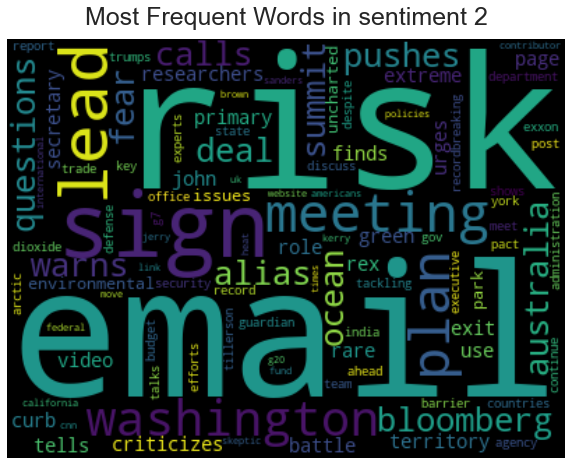

In [74]:
word_cloud(facts2, 2)

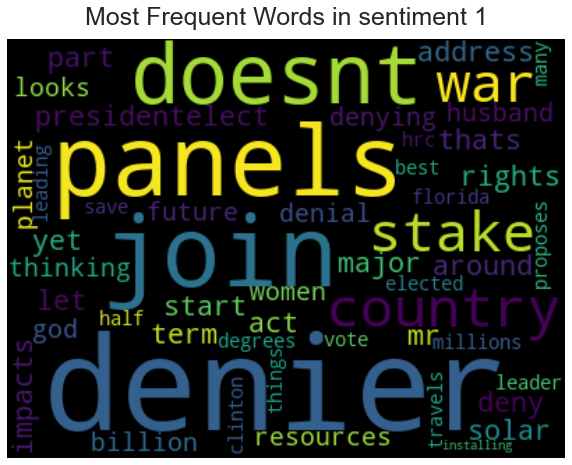

In [75]:
word_cloud(post2, 1)

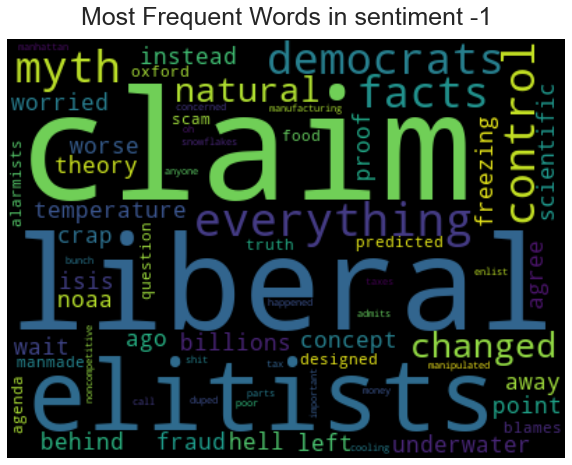

In [76]:
word_cloud(negt2, -1)

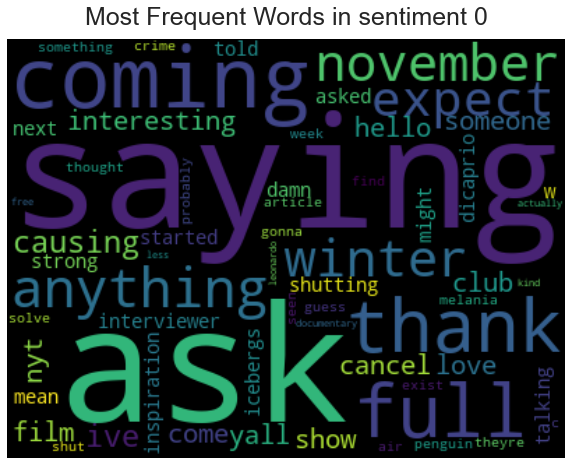

In [77]:
word_cloud(neut2, 0)

## Tokenize Text Data

Tokenization is the most primary step in any natural language processing model because machines cannot comprehend the language as it is, it must be transformed to numbers, which is where tokenization comes in handy. Tokenization is the process of breaking down sentences into words.

This appears straightforward, but there are a few drawbacks, mostly because we want to map each token to a number, and the size and meaning of the resulting mapping is vital for Machine Learning tasks.

There are a few tokenizers available, but for this program, we will be making use of the `TreebankWordTokenizer()`

In [78]:
def tokenize(text):
    tokenizer = TreebankWordTokenizer()
    
    return tokenizer.tokenize(text)

In [79]:
df['message'] = df['message'].apply(tokenize)

In [80]:
df.head()

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, does, not, think, c...",625221
1,1,"[it, is, not, like, we, lack, evidence, of, an...",126103
2,2,"[tag, researchers, say, we, have, three, years...",698562
3,1,"[target, wired, 2016, was, a, pivotal, year, i...",573736
4,1,"[tag, it, is, 2016, and, a, racist, sexist, cl...",466954


- [X] Token Text Data

## Transform data(by stemming or lemmatizing)

**Stemming** is the process of stripping a word of its suffix and reducing it to its underlying term.

For example: “Flying” is a word and its suffix is “ing”, if we remove “ing” from “Flying” then we will get base word or root word which is “Fly”. Read more about stemming [here](https://medium.com/@tusharsri/nlp-a-quick-guide-to-stemming-60f1ca5db49e#:~:text=NLP%3A%20A%20quick%20guide%20to%20Stemming%201%20OverStemming.,...%205%20Lancaster%20Stemmmer.%20...%206%20Conclusion.%20)

**Lemmatization** is not very different from **stemming** in that we are trying to reduce a given term to its root word in both stemming and lemmatization. In Natural Language Processing (NLP) and machine learning in general, lemmatization is one of the most used text pre-processing techniques. In the stemming process, the root word is termed a stem, and in the lemmatization process, it is called a lemma.

#### How do they differ?

In stemming, a portion of the word is simply sliced off at the end. Different methods are employed to determine how many letters must be removed, however the algorithms do not understand the meaning of the word in the language it belongs to. The algorithms in lemmatization, on the other hand, have this knowledge. In fact, you could argue that these algorithms consult a dictionary to figure out what a word means before reducing it to its root word, or lemma.
As a result, a lemmatization algorithm would recognize that **better** is derived from good, and hence the lemme is **good**.

A stemming algorithm, on the other hand, would be unable to do so. Over-stemming or under-stemming may occur, and the term **better** may be shortened to **bet** or **bett**, or simply **preserved as better**. However, there is no way to reduce it to its underlying word excellent by stemming. This is the main distinction between stemming and lemmatization.

In [81]:
def transform(text_list, method='lemma'):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    words = []
    if method == 'lemma':
        for word, tag in pos_tag(text_list):
            word_tag = tag[0].lower()
            word_tag = word_tag if word_tag in ['a', 'r', 'n', 'v'] else None
            if not word_tag:
                lemma = word
            else:
                lemma = lemmatizer.lemmatize(word, word_tag)
            
            words.append(lemma)

    elif method == 'stem':
        for word in text_list:
            stem = stemmer.stem(word)
            words.append(stem)
            
    else:
        return(f"ERROR: '{method}' is an unknown transformation method use 'stem' or 'lemma'")

    return words

In [82]:
df_copy = df.copy()

In [83]:
df_copy['message'] = df_copy['message'].apply(transform, method='stem')

In [84]:
df_copy.head()

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, doe, not, think, ca...",625221
1,1,"[it, is, not, like, we, lack, evid, of, anthro...",126103
2,2,"[tag, research, say, we, have, three, year, to...",698562
3,1,"[target, wire, 2016, wa, a, pivot, year, in, t...",573736
4,1,"[tag, it, is, 2016, and, a, racist, sexist, cl...",466954


In [85]:
df.head()

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, does, not, think, c...",625221
1,1,"[it, is, not, like, we, lack, evidence, of, an...",126103
2,2,"[tag, researchers, say, we, have, three, years...",698562
3,1,"[target, wired, 2016, was, a, pivotal, year, i...",573736
4,1,"[tag, it, is, 2016, and, a, racist, sexist, cl...",466954


- [X] Transform data(by stemming or lemmatizing)

We will be taking a look into vectorization and what it does

# Vectorization

Vectorization is a technical term for a classical approach of turning raw data (text) into vectors of real numbers, which is the format supported by machine learning models. This method has been around since the dawn of computing, has proven to be effective in a variety of fields, and is currently being employed in NLP.

Vectorization is a phase in feature extraction in Machine Learning. By translating text to numerical vectors, the goal is to extract some identifiable features from the text for the model to learn from.

There are a few vectorization techniques, we will look at 2 of the most popular methods;

1. Bag-of-words; which is practically a CountVectorizer.
2. TF-IDF Vectorization

#### Bag-of-words

Bag of words is a Natural Language Processing technique of text modelling. In technical terms, we can call it a method for extracting features from text data. This method of extracting features from documents is easy and adaptable.
A bag of words is a text representation that describes the frequency with which words appear in a document. We only keep track of word counts and don't pay attention to grammatical subtleties or word arrangement. Because any information about the sequence or structure of words in the document is deleted, it is referred to as a "bag" of words. The model simply cares about whether or not recognized terms appear in the document, not where they appear. [read more](https://www.mygreatlearning.com/blog/bag-of-words/)

#### TF-IDF

Term Frequency–Inverse Document Frequency, or TF-IDF, is a numerical statistic that measures how essential a word is in a document. It's not as naive as Bag of Words, but it's another frequency-based strategy.

## Vectorization without resampling

**Recall:** that presently our data is still in its **imbalanced** form, meaning all the sentiment types are not equally represented.

Now we will like to Vectorize out dataset in its imbalanced form, then in its balanced form.

In the mean time, let's refresh our memory on what our imbalanced data looks like

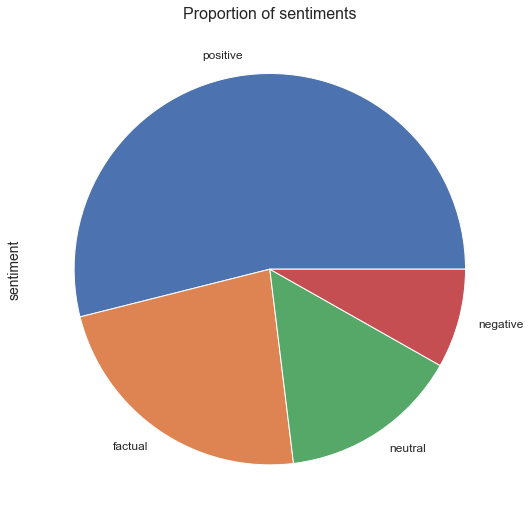

In [86]:
plot_series(df_copy.sentiment.value_counts(), name='sentiment')

Let's go ahead and Vectorize

### Split Data

In [87]:
X = df_copy['message']
y = df_copy['sentiment']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [89]:
def vectorize(data, method='tfidf'):
    data = [' '.join(x) for x in data]
    
    if method == 'tfidf':
        vector = TfidfVectorizer(lowercase=True, analyzer='word', ngram_range=(1, 2))
        vector.fit(data)
    else:
        vector = CountVectorizer(lowercase=True, analyzer='word', ngram_range=(1, 2))
        vector.fit(data)
    return vector

### Vectorization with **CountVectorizer**

In [90]:
cvvector = vectorize(X_train, method='cv')

In [91]:
X_train_cv = cvvector.transform([' '.join(x) for x in X_train])
X_test_cv = cvvector.transform([' '.join(x) for x in X_test])

print(X_train_cv.shape, X_test_cv.shape)

(11073, 71679) (4746, 71679)


### Vectorization with **TFIDFVectorizer**

In [92]:
tfidfvector = vectorize(X_train, method='tfidf')

In [93]:
X_train_tfidf = tfidfvector.transform([' '.join(x) for x in X_train])
X_test_tfidf = tfidfvector.transform([' '.join(x) for x in X_test])

print(X_train_tfidf.shape, X_test_tfidf.shape)

(11073, 71679) (4746, 71679)


#### What is an imbalanced data?

Imbalanced data refers to datasets in which the target class has an unequal distribution of observations, i.e. one class label has a large number of observations while the other has a small sample.

Because most machine learning algorithms for classification were created with the assumption of an equal number of samples for each class, imbalanced classifications provide a difficulty for predictive modeling. As a result, models with poor prediction accuracy, particularly for the minority class, emerge.

To deal with this problem, we use a concept called `resampling`

## Vectorization with sampling

#### What is  data resampling?

Resampling is a technique that involves taking multiple samples from the same set of data. It's a nonparametric approach of statistical inference, which means that it doesn't rely on generic distribution tables (such as normal distribution tables) to calculate estimated p probability values. Despite the benefits of balancing classes, these methods are not without flaws.

There are three types of resampling widely used:
 - **Under-sampling:**
     involves picking samples from the majority class at random and removing them from the training dataset. The majority class instances are removed at random until a more balanced distribution is attained in the random under-sampling method.
 - **Over-sampling:**
     requires replicating minority class instances at random and adding them to the training dataset.
 - **Hybrid:**
     this essentially combines both under-sampling and over-sampling to meet at a mid-way point

<img src="https://static-01.hindawi.com/articles/complexity/volume-2019/8460934/figures/8460934.fig.001.svgz" alt="drawing" width="800"/>

We will create a handy function that will enable us carry out the different sampling techniques as we see fit

In [94]:
def resampler(X_train, y_train, kind='oversample'):
    from imblearn.over_sampling import ADASYN
    from imblearn.under_sampling import RandomUnderSampler
    
    if kind == 'undersample':
        sampler = RandomUnderSampler(random_state=SEED)
    elif kind == 'oversample':
        sampler = ADASYN(random_state=SEED)
    else:
        print("Unrecognised sampling technique")
        
    X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
    
    return X_train_res, y_train_res

In [95]:
def sampling_plot_check(y1, y2):
    y1_dict = {}
    y2_dict = {}
    
    for xx in y1:
        if xx in y1_dict:
            y1_dict[xx] += 1
        else:
            y1_dict[xx] = 1
    
    for yy in y2:
        if yy in y2_dict:
            y2_dict[yy] += 1
        else:
            y2_dict[yy] = 1
            
    y1_series = pd.Series(y1_dict)
    y2_series = pd.Series(y2_dict)
    # y1_series.index = ['positive', 'factual', 'neutral', 'negative']
    # y2_series.index = ['positive', 'factual', 'neutral', 'negative']
    y1_series.plot(kind='bar', color='blue', alpha=1, figsize=(9, 6))
    y2_series.plot(kind='bar', color='orange',alpha=.7, figsize=(9, 6))
    plt.xticks(rotation=0)
    plt.show()

### First, we attempt under-sampling our data

In [96]:
cvvector_under = vectorize(X_train, method='cv')
X_train_cv_under = cvvector_under.transform([' '.join(x) for x in X_train])
X_test_cv_under = cvvector_under.transform([' '.join(x) for x in X_test])

X_train_under, y_train_under = resampler(X_train_cv_under, y_train, kind='undersample')

In [97]:
tfidfvector_tunder = vectorize(X_train, method='tfidf')
X_train_tfidf_tunder = tfidfvector_tunder.transform([' '.join(x) for x in X_train])
X_test_tfidf_tunder = tfidfvector_tunder.transform([' '.join(x) for x in X_test])

X_train_tunder, y_train_tunder = resampler(X_train_tfidf_tunder, y_train, kind='undersample')

Let's plot and see what we have

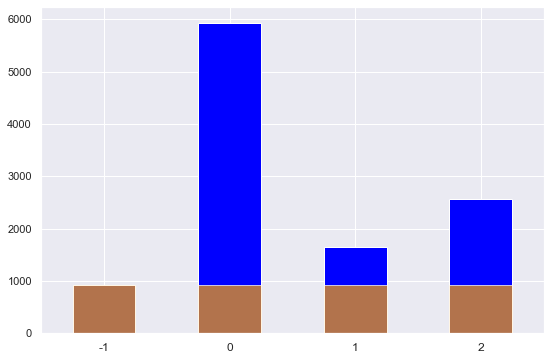

In [98]:
sampling_plot_check(y_train, y_train_under)
# y_train.value_counts()

### Next, we attempt over-sampling

In [99]:
cvvector_over = vectorize(X_train, method='cv')
X_train_cv_over = cvvector_over.transform([' '.join(x) for x in X_train])
X_test_cv_over = cvvector_over.transform([' '.join(x) for x in X_test])

X_train_over, y_train_over = resampler(X_train_cv_over, y_train, kind='oversample')

In [100]:
tfidfvector_tover = vectorize(X_train, method='tfidf')
X_train_tfidf_tover = tfidfvector_tover.transform([' '.join(x) for x in X_train])
X_test_tfidf_tover = tfidfvector_tover.transform([' '.join(x) for x in X_test])

X_train_tover, y_train_tover = resampler(X_train_tfidf_tover, y_train, kind='oversample')

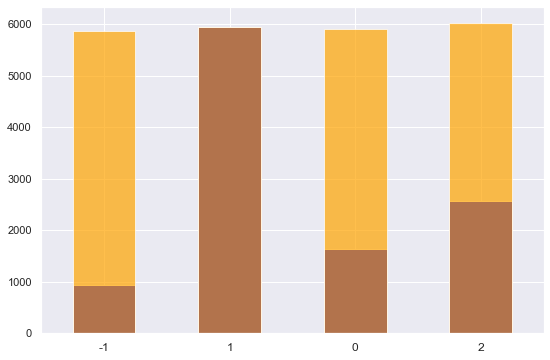

In [101]:
sampling_plot_check(y_train, y_train_over)

Wonderful!, everything looks equally balanced now.

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Modelling ⚡ |
| :--------------------------- |
| In this section, you are required to create one or more regression models that are able to accurately predict the thee hour load shortfall. |

---

In [102]:
def make_models(split, model_list, vectorizer_type='cv'):
    import warnings
    warnings.filterwarnings('ignore')
    
    for model in model_list:
        if model == 'logreg':
            modeller = LogisticRegression(multi_class='ovr', random_state=SEED)
        elif model == 'rfc':
            modeller = RandomForestClassifier(random_state=SEED)
        elif model == 'svc':
            modeller = SVC(random_state=SEED)
        elif model == 'bayes':
            if vectorizer_type == 'cv':
                print(f'using MultinomialNB') 
                modeller = MultinomialNB()
            elif vectorizer_type == 'tfidf':
                print(f'using GaussianNB')
                modeller = GaussianNB()
                
        else:
            print("unknown classifier")
        
        import time
        start = time.perf_counter()
        X_train, X_test, y_train, y_test = split
        
        try:
            modeller.fit(X_train, y_train)
        except TypeError:
            print("Unable to use gaussianNB")
            continue
            
        y_pred = modeller.predict(X_test)

        f_score = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred, labels=modeller.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neg', 'neu', 'pos', 'fact'])
        print(f'f1_score for {model} is : {f_score} \n\t\t')
        classification = classification_report(y_test, y_pred, target_names=['neg', 'neu', 'pos', 'fact'])
        print(classification)
        disp.plot()
        plt.show()
        print(f"it took {time.perf_counter() - start} secs for {model} to run.\n\n")

# Imbalanced Data Modelling

### CountVectorizer

In [103]:
split_data = (X_train_cv, X_test_cv,  y_train, y_test)
list_models = ['logreg', 'bayes']

f1_score for logreg is : 0.7320807310081188 
		
              precision    recall  f1-score   support

         neg       0.71      0.42      0.53       364
         neu       0.59      0.41      0.48       708
         pos       0.77      0.87      0.82      2593
        fact       0.75      0.78      0.77      1081

    accuracy                           0.74      4746
   macro avg       0.71      0.62      0.65      4746
weighted avg       0.73      0.74      0.73      4746



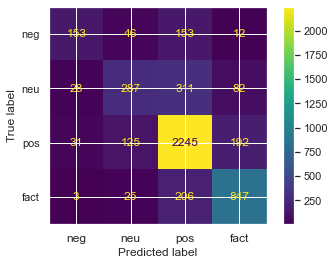

it took 65.74929840000004 secs for logreg to run.


using MultinomialNB
f1_score for bayes is : 0.6597559518266306 
		
              precision    recall  f1-score   support

         neg       0.85      0.13      0.22       364
         neu       0.83      0.18      0.29       708
         pos       0.67      0.95      0.79      2593
        fact       0.83      0.67      0.74      1081

    accuracy                           0.71      4746
   macro avg       0.80      0.48      0.51      4746
weighted avg       0.75      0.71      0.66      4746



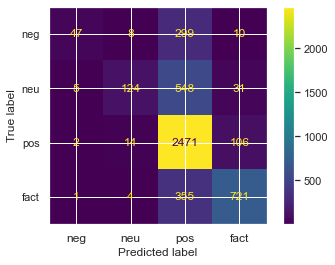

it took 1.227362200000016 secs for bayes to run.




In [104]:
make_models(split_data, list_models)

### TfidfVectorizer

In [105]:
split_data = (X_train_tfidf, X_test_tfidf, y_train, y_test)
list_models = ['logreg', 'bayes']

f1_score for logreg is : 0.678064396284243 
		
              precision    recall  f1-score   support

         neg       0.81      0.16      0.27       364
         neu       0.68      0.26      0.37       708
         pos       0.69      0.94      0.80      2593
        fact       0.80      0.67      0.73      1081

    accuracy                           0.72      4746
   macro avg       0.74      0.51      0.54      4746
weighted avg       0.72      0.72      0.68      4746



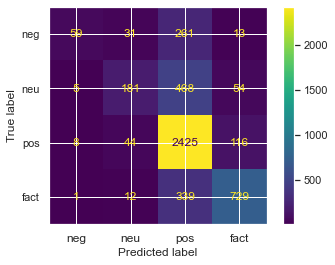

it took 16.844266000000005 secs for logreg to run.


using GaussianNB
Unable to use gaussianNB


In [106]:
make_models(split_data, list_models, vectorizer_type='tfidf')

# Resampled Data Modelling

## Over Sampling

### CountVectorizer

In [107]:
split_data = (X_train_over, X_test_cv_over,  y_train_over, y_test)
list_models = ['logreg', 'bayes']

f1_score for logreg is : 0.7171741997286702 
		
              precision    recall  f1-score   support

         neg       0.45      0.50      0.47       364
         neu       0.54      0.40      0.46       708
         pos       0.80      0.80      0.80      2593
        fact       0.71      0.81      0.76      1081

    accuracy                           0.72      4746
   macro avg       0.63      0.63      0.62      4746
weighted avg       0.72      0.72      0.72      4746



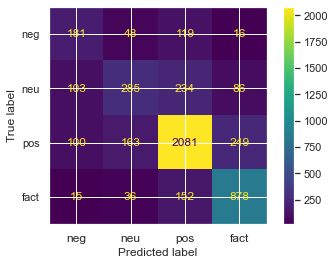

it took 37.6844284 secs for logreg to run.


using MultinomialNB
f1_score for bayes is : 0.6965711616872118 
		
              precision    recall  f1-score   support

         neg       0.48      0.32      0.38       364
         neu       0.64      0.30      0.41       708
         pos       0.74      0.86      0.79      2593
        fact       0.73      0.79      0.76      1081

    accuracy                           0.72      4746
   macro avg       0.65      0.57      0.59      4746
weighted avg       0.70      0.72      0.70      4746



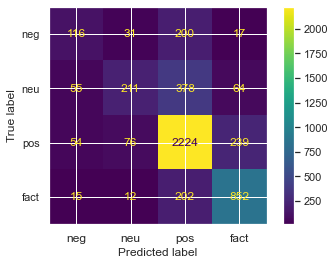

it took 1.4614535999999703 secs for bayes to run.




In [108]:
make_models(split_data, list_models)

### TfidfVectorizer

In [109]:
split_data = (X_train_tover, X_test_tfidf_tover, y_train_tover, y_test)
list_models = ['logreg', 'bayes']

f1_score for logreg is : 0.7163321278492177 
		
              precision    recall  f1-score   support

         neg       0.46      0.56      0.51       364
         neu       0.51      0.45      0.48       708
         pos       0.83      0.75      0.79      2593
        fact       0.69      0.86      0.77      1081

    accuracy                           0.72      4746
   macro avg       0.62      0.66      0.64      4746
weighted avg       0.72      0.72      0.72      4746



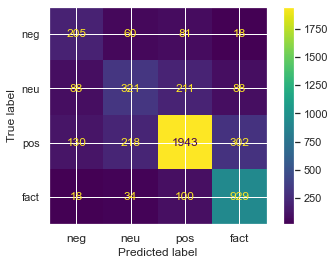

it took 35.023313299999984 secs for logreg to run.


using GaussianNB
Unable to use gaussianNB


In [110]:
make_models(split_data, list_models, vectorizer_type='tfidf')

## Under Sampling

### CountVectorizer

In [111]:
split_data = (X_train_under, X_test_cv_under,  y_train_under, y_test)
list_models = ['logreg', 'bayes']

f1_score for logreg is : 0.634426761753744 
		
              precision    recall  f1-score   support

         neg       0.34      0.63      0.44       364
         neu       0.39      0.53      0.45       708
         pos       0.86      0.56      0.68      2593
        fact       0.63      0.83      0.72      1081

    accuracy                           0.62      4746
   macro avg       0.55      0.64      0.57      4746
weighted avg       0.70      0.62      0.63      4746



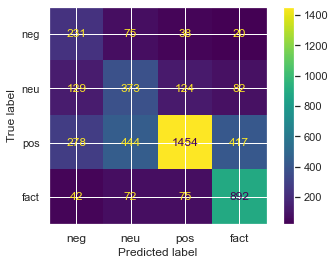

it took 28.632245300000022 secs for logreg to run.


using MultinomialNB
f1_score for bayes is : 0.6572865516162767 
		
              precision    recall  f1-score   support

         neg       0.30      0.70      0.42       364
         neu       0.47      0.35      0.40       708
         pos       0.79      0.69      0.73      2593
        fact       0.71      0.73      0.72      1081

    accuracy                           0.65      4746
   macro avg       0.57      0.62      0.57      4746
weighted avg       0.69      0.65      0.66      4746



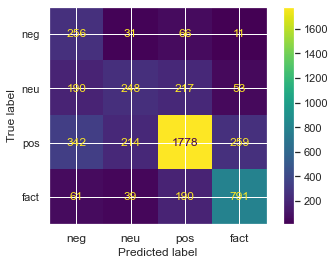

it took 1.5627306999999746 secs for bayes to run.




In [112]:
make_models(split_data, list_models)

### TfidfVectorizer

In [113]:
split_data = (X_train_tunder, X_test_tfidf_tunder, y_train_tunder, y_test)
list_models = ['logreg', 'bayes']

f1_score for logreg is : 0.6237599272261042 
		
              precision    recall  f1-score   support

         neg       0.34      0.65      0.44       364
         neu       0.39      0.42      0.40       708
         pos       0.83      0.58      0.68      2593
        fact       0.60      0.82      0.69      1081

    accuracy                           0.61      4746
   macro avg       0.54      0.61      0.55      4746
weighted avg       0.67      0.61      0.62      4746



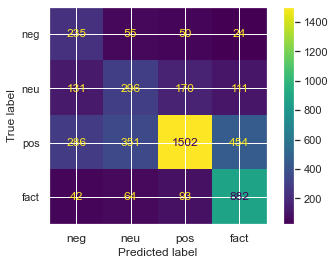

it took 14.814980399999968 secs for logreg to run.


using GaussianNB
Unable to use gaussianNB


In [114]:
make_models(split_data, list_models, vectorizer_type='tfidf')

### Predicting with Over sampled CountVectorized Data

In [115]:
model = LogisticRegression()
model.fit(X_train_over, y_train_over) # training resampled data from countvectorizer
y_pred = model.predict(X_test_cv)

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model performance ⚡ |
| :--------------------------- |
| In this section you are required to compare the relative performance of the various trained ML models on a holdout dataset and comment on what model is the best and why. |

---

In [116]:
# Compare model performance
import warnings
warnings.filterwarnings('ignore')
classification = classification_report(y_test, y_pred, target_names=['neg', 'neu', 'pos', 'fact'])

print(classification)

              precision    recall  f1-score   support

         neg       0.46      0.49      0.47       364
         neu       0.52      0.43      0.47       708
         pos       0.81      0.80      0.80      2593
        fact       0.72      0.80      0.76      1081

    accuracy                           0.72      4746
   macro avg       0.63      0.63      0.63      4746
weighted avg       0.72      0.72      0.72      4746



In [117]:
test_df = pd.read_csv('kaggle_data/test.csv', encoding='ascii', encoding_errors='ignore')

In [118]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [119]:
cols = list(test_df.columns)

cols

['message', 'tweetid']

## Clean test df

In [120]:
def preprocess(test, urls_csv):
    
    test['message'] = test['message'].apply_parallel(handle_weblinks)
    test['message'] = test['message'].apply(remove_stopwords)
    test['message'] = test['message'].apply(handle_tags)
    test['message'] = test['message'].apply(remove_punctuations)
    test['message'] = test['message'].apply(tokenize)
    test['message'] = test['message'].apply(transform, method='stem')
    
    return test

In [121]:
cols = test_df.columns

In [122]:
message = ['what is happening with will smith fake manmade scam', '800192']
payloader = dict(zip(cols, message)) 

In [123]:
payloader

{'message': 'what is happening with will smith fake manmade scam',
 'tweetid': '800192'}

In [124]:
def make_predictions(payload, data, model, vect = cvvector_over):
    payload_df = pd.DataFrame().from_dict([payload])
    data_s = pd.concat([data[:-1], payload_df])
    data_s.index = [x for x in range(10546)]
    
    X = preprocess(data_s, 'test_titles.csv')
    X_trans = vect.transform([' '.join(x) for x in X['message']])
    
    y_test_pred = model.predict(X_trans)
    
    if  y_test_pred[-1] == 1:
        print(f"The tweet is a Positive {y_test_pred[-1]} tweet")
    
    elif y_test_pred[-1] == -1:
        print(f"The tweet is a Negative {y_test_pred[-1]} tweet")
    
    elif y_test_pred[-1] == 0:
        print(f"The tweet is a Neutral {y_test_pred[-1]} tweet")
    
    elif y_test_pred[-1] == 2:
        print(f"The tweet is a Factual {y_test_pred[-1]} tweet")
        
    data_s['sentiment'] = y_test_pred
    
    return data_s

In [125]:
result = make_predictions(payloader, test_df, model)

result.sentiment.value_counts()

The tweet is a Negative -1 tweet


 1    5712
 2    2731
 0    1259
-1     844
Name: sentiment, dtype: int64

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model explanation ⚡ |
| :--------------------------- |
| In this section, you are required to discuss how the best performing model works in a simple way so that both technical and non-technical stakeholders can grasp the intuition behind the model's inner workings. |

---

In [126]:
# discuss chosen methods logic